# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Load-dataset-with-tine-annotations-(E-day)"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load dataset with tine annotations (E-day)</a></div><div class="lev1"><a href="#Select-mOMTN"><span class="toc-item-num">3&nbsp;&nbsp;</span>Select mOMTN</a></div><div class="lev1"><a href="#Select-variable-genes"><span class="toc-item-num">4&nbsp;&nbsp;</span>Select variable genes</a></div><div class="lev1"><a href="#Perform-a-likelihood-ratio-test"><span class="toc-item-num">5&nbsp;&nbsp;</span>Perform a likelihood ratio test</a></div><div class="lev2"><a href="#Define-functions"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define functions</a></div><div class="lev2"><a href="#Test-Significance"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Test Significance</a></div><div class="lev1"><a href="#Consider-the-subspace"><span class="toc-item-num">6&nbsp;&nbsp;</span>Consider the subspace</a></div><div class="lev1"><a href="#Pseudotime-using-principal-curve"><span class="toc-item-num">7&nbsp;&nbsp;</span>Pseudotime using principal curve</a></div><div class="lev2"><a href="#Infer-missing-values-using-the-correlation-structure"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Infer missing values using the correlation structure</a></div><div class="lev2"><a href="#Fit-a-curve-for-every-gene"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Fit a curve for every gene</a></div><div class="lev1"><a href="#Cluster-the-profiles-to-obtain-prototypical-dynamics"><span class="toc-item-num">8&nbsp;&nbsp;</span>Cluster the profiles to obtain prototypical dynamics</a></div><div class="lev1"><a href="#Plot-some-examples"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot some examples</a></div>

# Imports

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
import pandas as pd
from Cef_tools import *
from backSPIN import fit_CV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import stats
import rpy2.robjects as robj
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, FloatVector
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.cluster import AffinityPropagation
from sklearn.svm import SVR

In [51]:
def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

# Load dataset with tine annotations (E-day)

In [23]:
df, rows_annot, rows_annot, _ = cef2df('data/Mouse_Embryo_fulldataset.cef')

In [24]:
order_eday, Eday_ix = unique( cols_annot.ix['Timepoint'].values, return_inverse=True )
order_eday

array(['E11.5', 'E12.5', 'E13.5', 'E14.5', 'E15.5', 'E18.5'], dtype=object)

# Select mOMTN

In [25]:
bool_sel = (cols_annot.ix['Cell_type'] == 'mOMTN').values
df = df.ix[:, bool_sel]
Eday_ix = Eday_ix[bool_sel]

In [26]:
df = df.ix[df.sum(1) > 9, :]

# Select variable genes

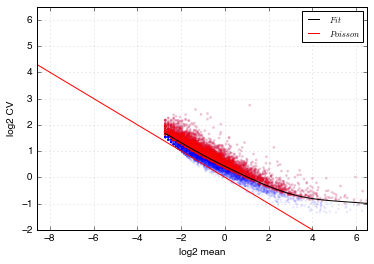

In [29]:
thrs = 5000

#Pre-filtering
df_f = df.copy()
df_f = df_f.ix[sum(df_f>=1, 1)>=5,:] # is at least 1 in X cells
df_f = df_f.ix[sum(df_f>=2, 1)>=2,:] # is at least 2 in X cells

#Fitting
mu = df_f.mean(1).values
sigma = df_f.std(1, ddof=1).values
cv = sigma/mu
score, mu_linspace, cv_fit , params = fit_CV(mu,cv, 'SVR')

#Plotting
figure()
scatter(log2(mu),log2(cv), marker='o', edgecolor ='none',alpha=0.1, s=5)
mu_sorted = mu[argsort(score)[::-1]]
cv_sorted = cv[argsort(score)[::-1]]
scatter(log2(mu_sorted[:thrs]),log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.15, s=8, c='r')
plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
plot(linspace(-9,7), -0.5*linspace(-9,7), '-r', label='$Poisson$')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
grid(alpha=0.3)
xlim(-8.6,6.5)
ylim(-2,6.5)
legend(loc=1, fontsize='small')
gca().set_aspect(1.2)

#Confirm Selection
df = df_f.ix[argsort(score)[::-1],:].ix[:thrs,:]
del df_f

In [30]:
# normalize
df_log = log2( df +1)
df_norm = df_log.subtract(df_log.mean(1), axis='rows')

# Perform a likelihood ratio test
   To test wether a gene has some variability over the time points comparing:
 - A GLM with a Negative binomial link function and time (E-day) as a categorical predictor 
 
 against
 
 
 - The null model that fits the data to a single nagative binomial distribution without taking time into account

## Define functions

In [40]:
def test_significance(df, group, family='NegativeBinomial', FDR_corrected=True):
    """
    df is a standard [genes,cells] pd.Dataframe
    groups is a vector of len = df.shape[1]
    """
    dfk = df.copy()
    
    p_values = []
    dfk.index = [ 'var'+str(i).zfill(5) for i in range(len(dfk.index))]
    for i, gene in enumerate(dfk.index):
        p_values.append( likelihood_ratio_test(dfk, group, gene, family=getattr(sm.families,family)() ) )
        if i % 100 == 0:
            print i,
    
    p_values = array(p_values)
    if FDR_corrected:
        q_values = multipletests(p_values, 0.5, 'fdr_bh')[1]
        print 'Returning q-values'
        return q_values
    else:    
        return p_values
    
def likelihood_ratio_test(df, group, gene, family):
    """ Performs a likelihood ratio test
    df is a standard [genes,cells] pd.Dataframe
    groups is a vector of len = df.shape[1]
    """
    assert len(group) == df.shape[1], 'groups and df have not compatible shape'
    expression = df.T
    expression['Groups'] = group
    
    #Fit the full and the restricted model

    model_full = smf.glm('%s ~ C(Groups)' % gene , family=family, data=expression)
    model_res = smf.glm('%s ~ 1' % gene , family=family, data=expression)
    results_full = model_full.fit()
    results_res = model_res.fit()
    
    lrdf = (results_res.df_resid - results_full.df_resid) #degrees of freedom
    lrstat = -2*(results_res.llf - results_full.llf) # test statistics, using the log likelihood
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf) #perform statistic test
    
    return lr_pvalue

## Test Significance

In [41]:
q_values = test_significance(df, Eday_ix, family='NegativeBinomial', FDR_corrected=True)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 Returning q-values


In [43]:
sum( q_values<0.1 )

380

# Consider the subspace
- that includes only the genes that have significant variation over time
- excluding genes that are marker of other cell types
(to avoid the genes variable because of a contamination event)

In [44]:
df_sign_genes = df.ix[q_values<0.1,:]
df_sign_genes_norm = df_norm.ix[q_values<0.1,:]

In [46]:
pattern_df = pd.read_csv('data/Mouse_binary.tsv',sep='\t', index_col=0)

bool1 = (pattern_df.ix[:,'mOMTN'] & (pattern_df.sum(1) < 4) & 
         ~(pattern_df.ix[:,'mEndo'])).values

cleaned_list = list(set(df_sign_genes.index.tolist()) & set(pattern_df.index[bool1]) )

In [47]:
df_sign_genes = df_sign_genes.ix[cleaned_list,:]
df_sign_genes_norm = df_sign_genes_norm.ix[cleaned_list,:]

# Pseudotime using principal curve

In [52]:
res = principal_curve(df_sign_genes_norm.T.values)
print res.PCs.shape[1]

4


## Infer missing values using the correlation structure
(from the rest of the transcriptome)

In [53]:
def infer_gene(df, gene,verbose=False, **kwargs):
    lasso = Lasso(**kwargs)
    X = df.ix[df.index !=gene,:].values.T.astype(float)
    y = df.ix[gene].values.T.astype(float)
    results = lasso.fit(X, y)
    if verbose:
        print sum( abs( results.coef_ ) > 0.05),
    return lasso.predict(X)

def gene_inference(df,gene_list,verbose,**kwargs):
    return pd.DataFrame(data=[infer_gene(df,gene, verbose, **kwargs) for gene in gene_list  ], index = gene_list, columns=df.columns)

In [56]:
#Include all the genes and repeat inference
df_sign_genes_norm = df_norm.ix[q_values<0.1,:]

df_sign_genes_norm_inferred =gene_inference(df_sign_genes_norm,\
                                            df_sign_genes_norm.index.values.tolist(),verbose=True, alpha=0.1)
#WITHOUT INCLUDING
sorted_df_norm_temp = df_sign_genes_norm_inferred.ix[:,res.ixsort[::-1]].T
sorted_df_norm_temp['Pseudotime'] =  max(res.arclength) - res.arclength[res.ixsort[::-1]]
sorted_df_norm_pseudotime = sorted_df_norm_temp

11 6 5 4 21 12 7 3 11 6 8 14 2 13 10 21 12 16 6 10 12 9 1 8 2 5 4 7 5 10 2 17 17 2 4 4 11 12 15 6 25 2 3 2 2 4 6 7 5 2 10 10 9 4 5 4 5 3 1 11 5 3 7 6 5 11 10 14 11 3 11 7 22 8 10 13 2 7 4 7 26 8 9 13 5 9 5 9 1 2 1 2 4 5 11 0 8 6 11 8 9 5 11 1 12 2 1 3 2 9 11 13 6 1 13 1 4 5 2 13 8 16 13 5 6 4 11 4 6 3 2 1 4 4 5 2 6 4 4 12 16 4 4 7 14 2 5 15 9 2 11 2 6 2 9 4 5 1 4 2 17 11 1 4 1 6 2 1 5 4 2 2 5 5 3 2 4 15 2 7 3 2 10 15 8 8 2 4 6 5 5 2 1 6 3 6 7 1 3 3 5 4 12 11 9 9 15 7 10 5 6 3 13 4 3 2 6 3 4 2 7 9 3 6 7 3 4 5 12 7 12 3 4 0 8 3 1 1 7 6 6 9 4 2 4 7 10 6 3 5 2 4 4 4 2 5 5 13 2 4 6 4 4 3 12 1 0 2 0 4 10 3 10 3 5 3 1 3 3 8 7 2 2 8 10 4 3 5 18 6 5 11 5 1 2 2 2 8 5 2 0 9 1 5 10 6 2 3 3 2 1 4 0 1 3 5 0 6 3 9 4 13 1 1 1 2 11 5 3 6 2 3 4 2 1 2 5 3 6 4 3 6 1 3 3 7 2 4 5 10 1 1 8 8 0 1 2 2 2 3 4 5 1 11 4 0 2 0 9 1 4 7 2 0 7 3 11 4 3 3


## Fit a curve for every gene

In [67]:
from collections import Counter
Counter(Eday_ix)

Counter({0: 19, 1: 13, 2: 17, 3: 7, 4: 9, 5: 1})

In [85]:
len(list(R2_df.iteritems()))

15

In [87]:
lin = linspace(0,max(sorted_df_norm_pseudotime.Pseudotime),400)
predictions_df = pd.DataFrame()
R2_df = {}
for i in sorted_df_norm_pseudotime:
    svr = GridSearchCV(SVR(kernel='rbf'), cv=ShuffleSplit(len(Eday_ix), test_size=0.5,n_iter=8),\
                       param_grid={"C": [1,2,5,7],\
                                   "gamma": linspace(0.001,0.004,6)})
    svr.fit(sorted_df_norm_pseudotime.ix[:, 'Pseudotime'].values[:,newaxis], sorted_df_norm_pseudotime.ix[:, i].values)
    R2 = svr.score(sorted_df_norm_pseudotime.ix[:, 'Pseudotime'].values[:,newaxis], sorted_df_norm_pseudotime.ix[:, i].values)
    if R2 >0.35:
        predictions_df[i] = svr.predict(lin[:,newaxis])
        R2_df[i] = R2

In [88]:
predictions = predictions_df.values

In [89]:
predictions = predictions - predictions.min(0)
predictions = predictions / predictions.mean(0)

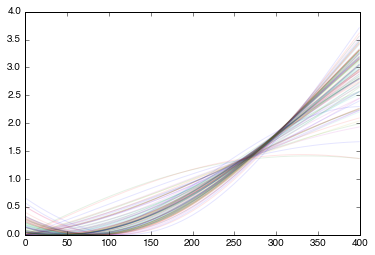

In [94]:
# quick visualization of 50 exaples of fit
for i in range(100):
    plot( predictions[:,i], alpha=0.1 )

# Cluster the profiles to obtain prototypical dynamics

In [95]:
ap = AffinityPropagation(damping=0.8, max_iter=500,\
                         convergence_iter=30, copy=True,\
                         preference=-400, affinity='euclidean')
labels = ap.fit_predict(predictions.T )
len( set( labels ) )

2

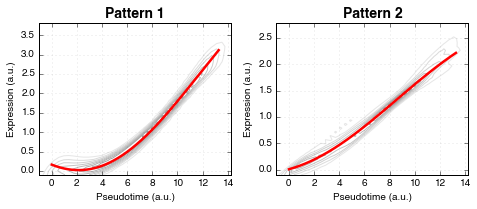

In [97]:
from scipy import stats
fig = figure(figsize(10,4.5*len(set(labels)) /3.))
l_set = array( list(set(labels)) )
for n,i in enumerate( l_set[argsort([sum(labels==k) for k in  l_set])[::-1]] ):
    subplot(int( ceil( len(set(labels)) /3.)), 3, n+1)
    y = predictions[:,labels == i].flatten()
    mean_y = mean( predictions[:,labels == i], 1)
    x = repeat(lin,sum(labels == i) )
    X, Y = mgrid[min(x)-1:max(x)+1:40j, min(y)-0.1:max(y)+0.1:40j]
    positions = vstack([X.ravel(), Y.ravel()])
    values = vstack([x,y])
    kernel = stats.gaussian_kde(values)
    Z = reshape(kernel(positions).T, X.shape)
    contour(X,Y,Z,10, colors=[(j,)*3 for j in linspace(0.6,0.9,8)[::-1]])
    plot(lin, mean_y, c='r', lw=2.5)
    xlabel('Pseudotime (a.u.)')
    ylabel('Expression (a.u.)')
    grid(alpha=0.2)
    title('Pattern %i' % (n+1), fontdict={'size':14,'weight':'semibold'})
tight_layout()

In [98]:
genes_by_pattern = [predictions_df.columns[ labels==i ].tolist() for i in l_set[argsort([sum(labels==k) for k in  l_set])[::-1]]]

# Plot some examples

In [99]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            #spine.set_position(('outward', 10))  # outward by 10 points
            #spine.set_smart_bounds(True)
            pass
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [104]:
color_list = [(231,47,39),(255,200,8),(19,166,50),(1,124,141),(1,84,201), (43,56,86)]

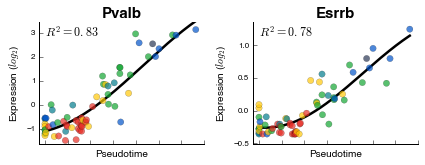

In [140]:
gene_toplot = [ 'Pvalb', 'Esrrb'] 
figure(figsize=(6,2.4))
for n, gene in enumerate(array(gene_toplot)[argsort([R2_df[j] for j in gene_toplot])[::-1]]):
    subplot(int(ceil( len(gene_toplot) / 2.)), 2, n+1)
    plot(lin, predictions_df.ix[:,gene], '-k', linewidth=2.5, zorder=-1)
    scatter(sorted_df_norm_pseudotime.Pseudotime,\
            sorted_df_norm_pseudotime[gene],
            c=array(color_list)[Eday_ix[res.ixsort[::-1]],:]/255., s=40,alpha=0.7,lw=0.2, zorder=100)
    text(0.2,0.92,r'$R^2 = %.2f$' % R2_df[gene], ha='center', va='center',transform = gca().transAxes,\
         fontdict={'weight':'semibold', 'size':'12', 'family':'Times'})
    title(gene, size=15, weight='semibold')
    adjust_spines(gca(), ['left', 'bottom'])
    gca().yaxis.set_tick_params(labelsize=8)
    gca().xaxis.set_tick_params(labelbottom='off')
    xlim([0-0.5,ceil(max(lin))])
    ylim(percentile(sorted_df_norm_pseudotime[gene], 0.5)-0.15,percentile(sorted_df_norm_pseudotime[gene]*1.1, 99.9))
    xlabel('Pseudotime')
    ylabel('Expression ($log_2$)')
    #grid(alpha=0.2)
tight_layout()